# Semi-Automatic Masking Workflow
Minimize manual effort and train a segmentation model!

In [ ]:
# 1. Imports
%pip install -q opencv-python
import cv2, os, numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
print("done!")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


RuntimeError: 'widget is not a recognised GUI loop or backend name

## 2. Image Loader
Read images for annotation.

In [2]:
import random
IMG_DIR = 'raw_img'  # Your images directory
img_files = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.jpg', '.png'))]

# Take a random sample of 50 files (or fewer if there are less than 50)
sample_size = min(50, len(img_files))
sampled_files = random.sample(img_files, sample_size)

# Load the sampled images
images = [cv2.imread(os.path.join(IMG_DIR, f)) for f in sampled_files]
print(f"Loaded {len(images)} images.")

Loaded 50 images.


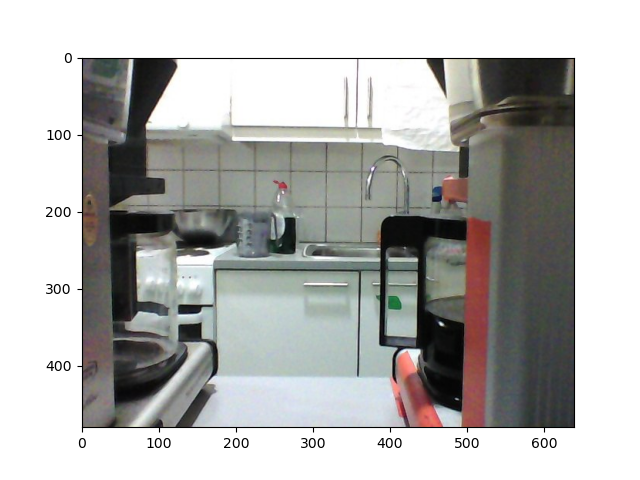

In [3]:
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

In [ ]:
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path

class MultiPolygonMaskBuilder:
    def __init__(self, image):
        if not isinstance(image, np.ndarray):
            raise ValueError("Image must be a numpy array")
        if image.dtype == object:
            raise ValueError("Image array must not have dtype=object")
        self.image = image
        self.fig, self.ax = plt.subplots()
        self.ax.imshow(self.image)
        self.polygons = []
        self.current_selector = PolygonSelector(self.ax, self.onselect)
        self.cid = self.fig.canvas.mpl_connect('key_press_event', self.on_key_press)
        print("Instructions:")
        print("- Draw a polygon by clicking points. Double-click to finish each polygon.")
        print("- Press 'n' to start a new polygon.")
        print("- Press 'm' to show mask.")
        print("- Press 'q' to quit.")
        self.mask = np.zeros(self.image.shape[:2], dtype=np.uint8)
        plt.show()

    def onselect(self, verts):
        self.polygons.append(verts)
        # Draw the current polygon on the image
        xs, ys = zip(*verts)
        self.ax.plot(xs + (xs[0],), ys + (ys[0],), color='red')
        self.fig.canvas.draw_idle()
        print(f"Polygon {len(self.polygons)} added. Press 'n' for new, 'm' to show mask, 'q' to quit.")

    def on_key_press(self, event):
        if event.key == 'n':
            # Start a new polygon
            self.current_selector.disconnect_events()
            self.current_selector = PolygonSelector(self.ax, self.onselect)
        elif event.key == 'm':
            # Show mask
            self.update_mask()
            plt.figure()
            plt.imshow(self.mask, cmap='gray')
            plt.title('Combined Mask')
            plt.show()
        elif event.key == 'q':
            plt.close(self.fig)
            self.fig.canvas.mpl_disconnect(self.cid)

    def update_mask(self):
        # Fill all polygons in mask
        mask = np.zeros(self.image.shape[:2], dtype=np.uint8)
        for verts in self.polygons:
            path = Path(verts)
            ny, nx = self.image.shape[:2]
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x, y)).T
            grid = path.contains_points(points)
            poly_mask = grid.reshape((ny, nx)).astype(np.uint8) * 255
            mask = np.maximum(mask, poly_mask)
        self.mask = mask
    
print("done!")

done!


## 3. Manual Masking
Draw polygons on a few images to create initial masks.

opening image...
Instructions:
- Draw a polygon by clicking points. Double-click to finish each polygon.
- Press 'n' to start a new polygon.
- Press 'm' to show mask.
- Press 'q' to quit.


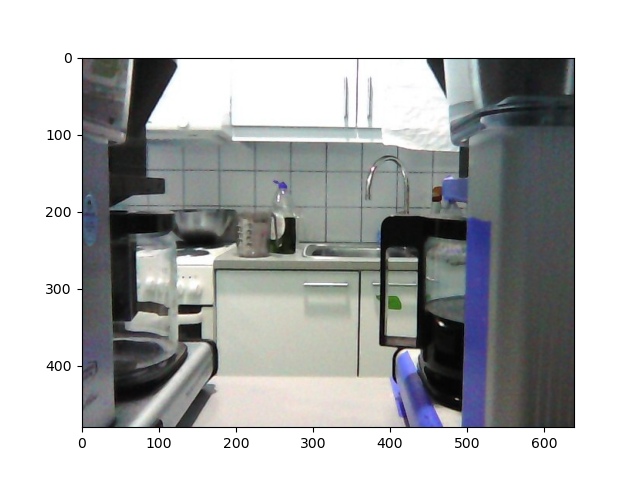

opening image...
Instructions:
- Draw a polygon by clicking points. Double-click to finish each polygon.
- Press 'n' to start a new polygon.
- Press 'm' to show mask.
- Press 'q' to quit.


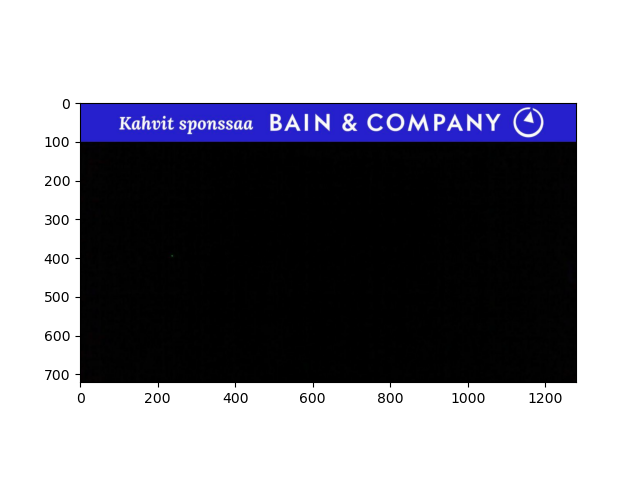

opening image...
Instructions:
- Draw a polygon by clicking points. Double-click to finish each polygon.
- Press 'n' to start a new polygon.
- Press 'm' to show mask.
- Press 'q' to quit.


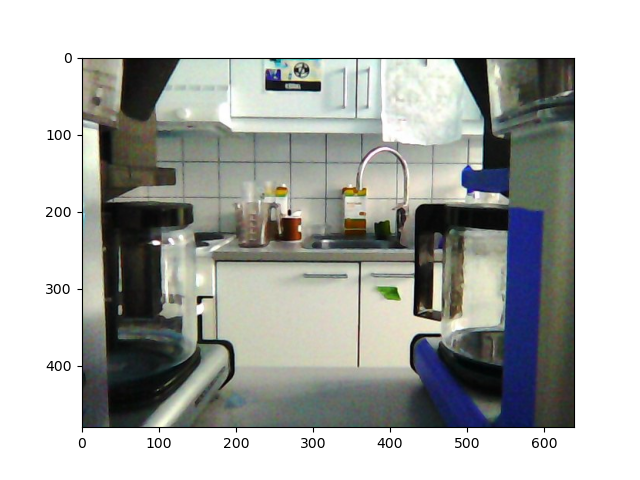

opening image...
Instructions:
- Draw a polygon by clicking points. Double-click to finish each polygon.
- Press 'n' to start a new polygon.
- Press 'm' to show mask.
- Press 'q' to quit.


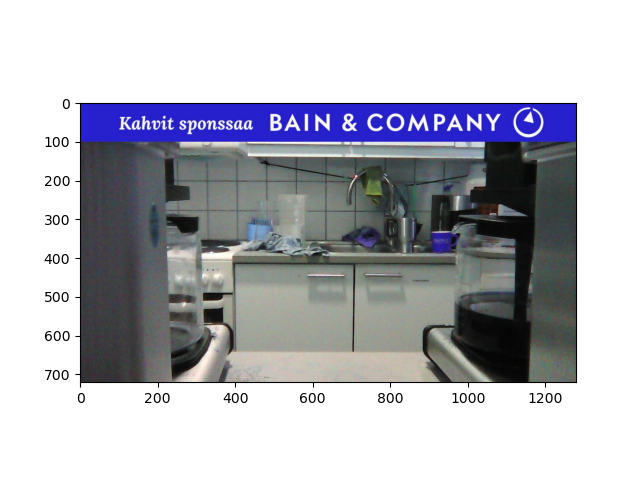

opening image...
Instructions:
- Draw a polygon by clicking points. Double-click to finish each polygon.
- Press 'n' to start a new polygon.
- Press 'm' to show mask.
- Press 'q' to quit.


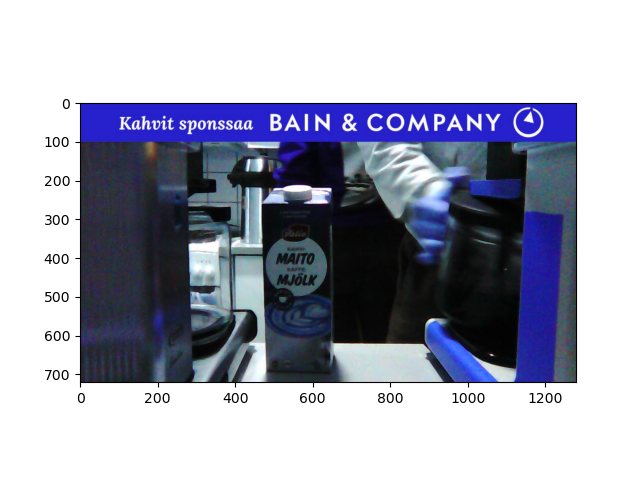

In [7]:
# Utility: Draw mask with OpenCV (polygon annotation)

# Demo: Annotate first 5 images
manual_masks = []
for img in images[:5]:
    print("opening image...")
    mask = MultiPolygonMaskBuilder(img)
    manual_masks.append(mask.mask)

## 4. Save Manual Masks
These become your first training labels.

In [10]:
os.makedirs('manual_masks', exist_ok=True)
for fname, mask in zip(img_files[:5], manual_masks):
    cv2.imwrite(f'manual_masks/mask_{fname}', mask)

## 5. Next: Model Training
You can now train a segmentation model using the images and masks in `manual_masks/`.
- Use a notebook or a script with PyTorch, Keras, or your favorite framework.
- After initial training, predict masks on more images and correct as needed (pseudo-labeling).